In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import datetime
from scipy.stats import norm
from matplotlib import gridspec
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import plotly.express as px

np.set_printoptions(suppress=True)
sns.set_theme()

%matplotlib inline

## Russia

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
start_date = '2020-03-03'

In [4]:
df_russia = df[(df.location == "Russia") & (df.date >= start_date)].copy()

In [5]:
def to_date(date):
  return datetime.datetime.strptime(date, '%Y-%m-%d')

In [6]:
start_date_dt = to_date(start_date)
train_end_date_dt = start_date_dt + datetime.timedelta(days=50)

In [7]:
df_russia.loc[df_russia['new_cases'] == 0, 'new_cases'] = 1
df_russia.loc[:, 'day_num'] = np.arange(len(df_russia))
df_russia.loc[:, 'date'] = pd.to_datetime(df_russia['date'], infer_datetime_format=True)

In [8]:
train = df_russia[df_russia.date <= train_end_date_dt].copy()
test = df_russia[df_russia.date > train_end_date_dt].copy()

Text(0.5, 1.0, 'New cases')

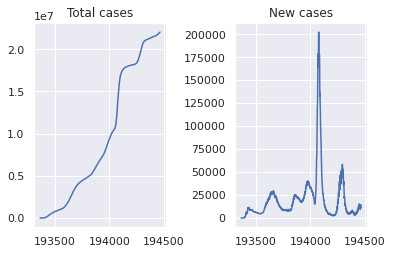

In [9]:
fig, ax = plt.subplots(1, 2)

fig.tight_layout(pad=3.0)
ax[0].plot(df_russia.total_cases)
ax[0].set_title('Total cases')

ax[1].plot(df_russia.new_cases)
ax[1].set_title('New cases')

In [10]:
X = df_russia.day_num.to_numpy().reshape((-1, 1))
y = df_russia.new_cases.values

In [11]:
X_train = train.day_num.to_numpy().reshape((-1, 1))
y_train = train.new_cases.values

In [12]:
model = LinearRegression(fit_intercept=True).fit(X_train, np.log(y_train))

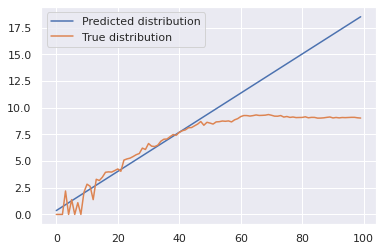

In [13]:
plt.plot(model.predict(X)[:100], label="Predicted distribution")
plt.plot(np.log(y)[:100], label="True distribution")
plt.legend(loc='upper left')

In [16]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [17]:
sigma = np.std(np.log(y_train) - model.predict(X_train)).round(1)
sigma

0.6

In [18]:
def bayesian_update_loop(X, y, sigma_noise=0.6):
  mu = np.array([0, 0])
  sigma = 100 * np.array([[1, 0], [0, 1]])

  for x, y in zip(X, y):
    mu, sigma = bayesian_update(mu, sigma, x[0], np.log(y), sigma_noise)

  return mu, sigma

In [19]:
mu, sigma = bayesian_update_loop(X_train, y_train)

(0.0, 22026.465794806718)

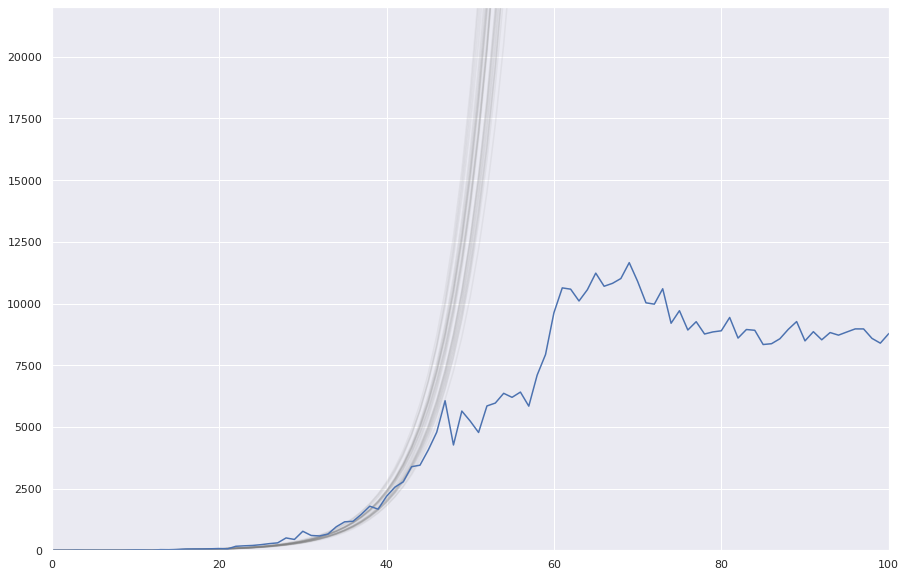

In [20]:
plt.figure(figsize=(15, 10))
ax = plt.gca()

random_exp = np.random.multivariate_normal(mu, sigma, 30)
x_wb = np.array([[1, x[0]] for x in X])

for exp in random_exp:
    ax.plot(X.reshape(-1), np.exp(np.dot(x_wb, exp)), color=[0.5, 0.5, 0.5], alpha=.1)

plt.plot(X.reshape(-1), y)

ax.set_xlim((0, 100))
ax.set_ylim((0, np.exp(10)))

In [21]:
test_dates = df_russia[df_russia.date.isin([to_date('2020-05-01'), to_date('2020-06-01'), to_date('2020-09-01')])]

In [22]:
test_predictions = []
x_wb = np.array([[1, x] for x in test_dates.day_num])

for exp in random_exp:
  test_predictions.append(np.exp(np.dot(x_wb, exp)))

test_predictions = np.array(test_predictions)

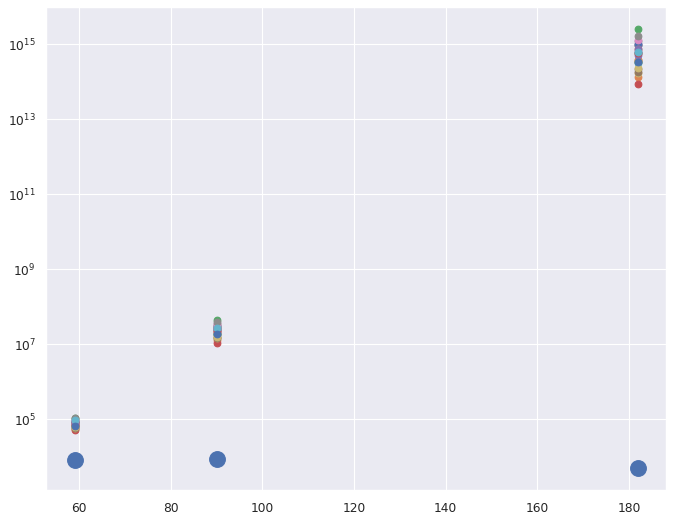

In [23]:
fig = plt.figure(figsize=(10, 8), dpi=80)
ax = fig.add_subplot(111)
ax.set_yscale('log')

ax.scatter(test_dates.day_num, test_dates.new_cases, s=200)
for pred in test_predictions:
  ax.scatter(test_dates.day_num, pred)

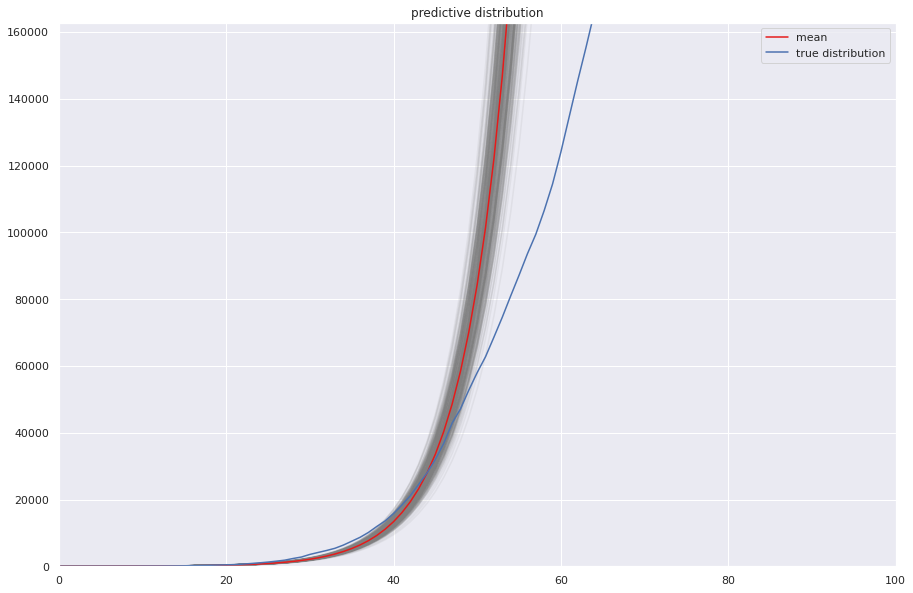

In [24]:
fig = plt.figure(figsize=(15, 10))
ax = plt.gca()
x_wb = np.array([[1, x] for x in X.reshape(-1)]).reshape((-1, 2))

predictions_total = []

random_exp = np.random.multivariate_normal(mu, sigma, 300)
for exp in random_exp:
    predictions = np.cumsum(np.exp(np.dot(x_wb, exp)))
    predictions_total.append(predictions)
    ax.plot(X.reshape(-1), predictions, color=[0.5, 0.5, 0.5], alpha=.1)

ax.plot(X.reshape(-1), np.array(predictions_total).mean(axis=0), color=[0.9, 0.1, 0.1], label='mean')
ax.plot(X.reshape(-1), df_russia.total_cases.values, 'b', label='true distribution')

ax.set_xlim((0, 100))
ax.set_ylim((0, np.exp(12)))
ax.set_title('predictive distribution')
ax.legend()

Assuming that cumulative distribution function $ \Phi(x) $ can be written as ${\frac{1}{\sqrt{2\pi}}}\int_{-\infty }^{x}e^{-x^{2}/2}\,dx $, its derivetive will be $ {\sqrt{\frac{1}{2\pi}}}e^{-x^{2}/2} $. Previously we wad simple exponential model, but now it has quadratic function, thus we can denote $y$ as $e^{w_{0} + w_{1} \cdot x + w_{2} \cdot x^{2}}$. So model can be learned using previouss approach, but with additional term $w_{2} \cdot x^{2}$

In [25]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x, x**2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [26]:
def bayesian_update_loop(X, y, sigma_noise=0.6):
  mu = np.zeros(3)
  sigma = 100 * np.diag(np.ones(3))

  for x, y in zip(X, y):
    mu, sigma = bayesian_update(mu, sigma, x[0], np.log(y), sigma_noise)

  return mu, sigma

In [27]:
mu, sigma = bayesian_update_loop(X_train, y_train)

(0.0, 15.0)

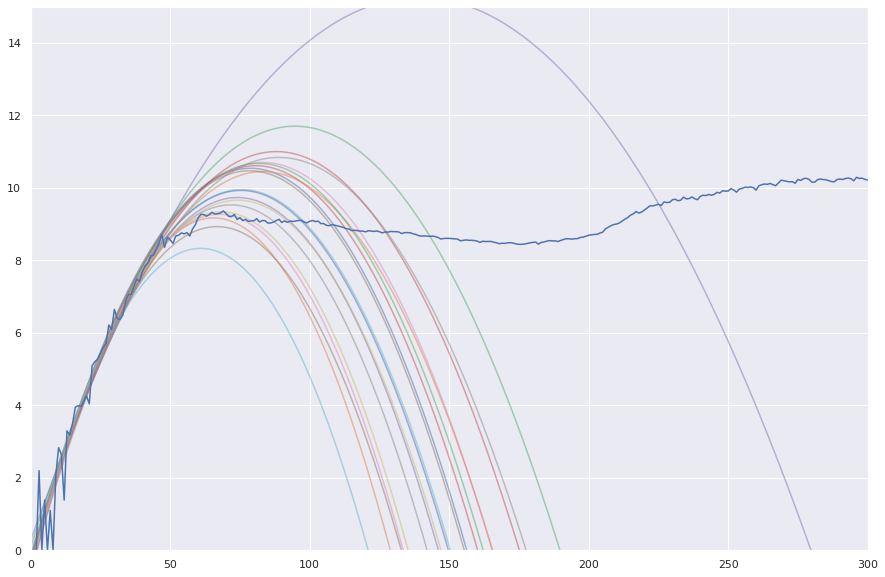

In [28]:
plt.figure(figsize=(15, 10))
ax = plt.gca()

random_exp = np.random.multivariate_normal(mu, sigma, 20)
x_wb = np.array([[1, x[0], x[0]**2] for x in X])

for exp in random_exp:
    ax.plot(X.reshape(-1), np.dot(x_wb, exp), alpha=.5)

plt.plot(X.reshape(-1), np.log(y))

ax.set_xlim((0, 300))
ax.set_ylim((0, 15))

In [29]:
test_predictions = []
x_wb = np.array([[1, x, x**2] for x in test_dates.day_num])

for exp in random_exp:
  test_predictions.append(np.exp(np.dot(x_wb, exp)))

test_predictions = np.array(test_predictions)

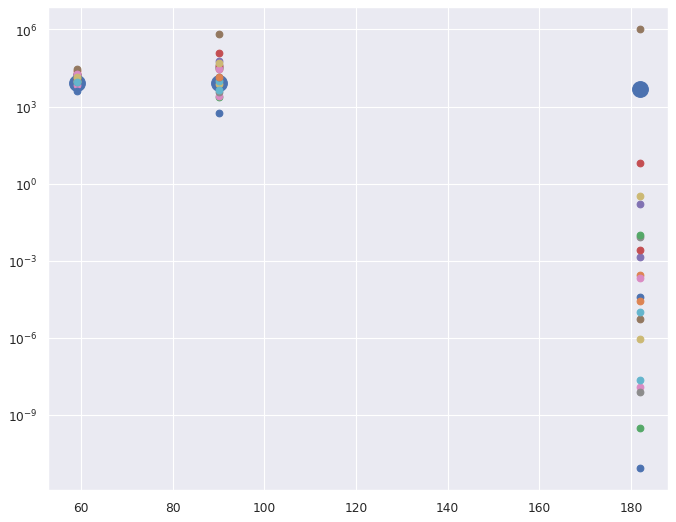

In [30]:
fig = plt.figure(figsize=(10, 8), dpi=80)
ax = fig.add_subplot(111)
ax.set_yscale('log')

ax.scatter(test_dates.day_num, test_dates.new_cases, s=200)
for pred in test_predictions:
  ax.scatter(test_dates.day_num, pred)

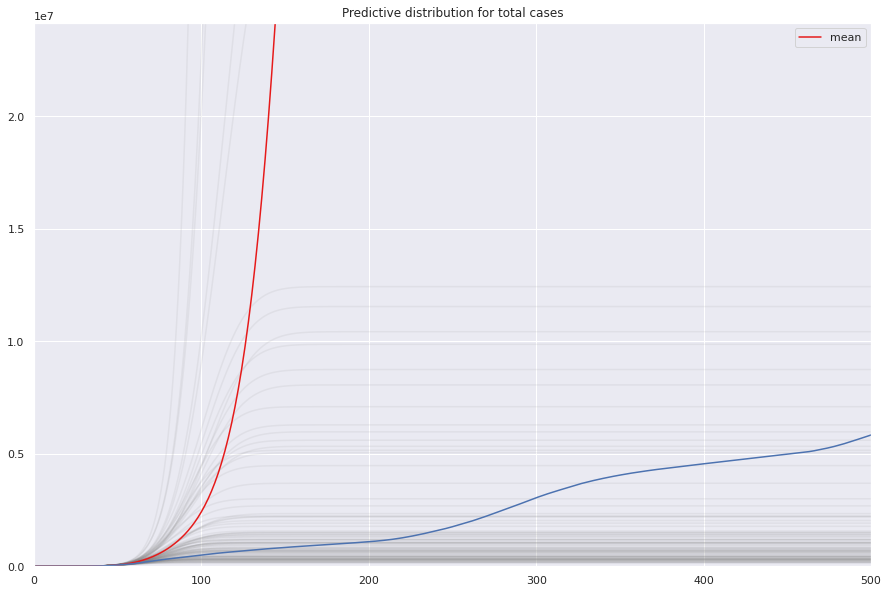

In [32]:
fig = plt.figure(figsize=(15, 10))
ax = plt.gca()
x_wb = np.array([[1, x, x**2] for x in X.reshape(-1)]).reshape((-1, 3))

predictions_total = []

random_exp = np.random.multivariate_normal(mu, sigma, 100)
for exp in random_exp:
    predictions = np.cumsum(np.exp(np.dot(x_wb, exp)))
    predictions_total.append(predictions)
    ax.plot(X.reshape(-1), predictions, color=[0.5, 0.5, 0.5], alpha=.1)

ax.plot(X.reshape(-1), np.array(predictions_total).mean(axis=0), color=[0.9, 0.1, 0.1], label='mean')
ax.plot(X.reshape(-1), df_russia.total_cases.values, 'b')

ax.set_xlim((0, 500))
ax.set_ylim((0, np.exp(17)))

ax.set_title('Predictive distribution for total cases')
ax.legend()

In [33]:
random_exp = np.random.multivariate_normal(mu, sigma, 10**5)
total_cases = []
for exp in random_exp:
    total_cases.append(np.cumsum(np.exp(np.dot(x_wb, exp)))[-1])

total_cases = np.array(total_cases)

In [34]:
print(f'10th percentile: {np.percentile(total_cases, 10)}')
print(f'90th percentile: {np.percentile(total_cases, 90)}')
print(f'95th percentile: {np.percentile(total_cases, 95)}')
print(f'True amount: {df_russia.total_cases.values[-1]}')

10th percentile: 259003.65117070207
90th percentile: 5513010.683050603
95th percentile: 13683235.144628841
True amount: 22040875.0


## Other countries

In [35]:
def get_parameters(df):
  df = df.fillna(0)
  df.loc[df['new_cases'] == 0, 'new_cases'] = 1
  df.loc[:, 'day_num'] = np.arange(len(df))
  df.loc[:, 'date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

  X = df.day_num.to_numpy().reshape((-1, 1))
  y_new = df.new_cases.values
  y_total = df.total_cases.values
  X_train = X[:50]
  y_train = y_new[:50]

  model = LinearRegression(fit_intercept=True).fit(X_train, np.log(y_train))
  sigma_noise = np.std(np.log(y_train) - model.predict(X_train)).round(1)

  mu, sigma = bayesian_update_loop(X_train, y_train, sigma_noise=sigma_noise)

  return mu, sigma, y_total[49], y_total[-1], 

In [36]:
def get_countries_params(countries, start_dates):
  mu_countries = []
  sigma_countries = []
  train_last_totals = []
  last_totals = []

  for country, start_date in zip(countries, start_dates):
    mu, sigma, train_last_total, last_total = get_parameters(df[(df.location == country) & (df.date >= start_date)].copy())
    
    mu_countries.append(mu)
    sigma_countries.append(sigma)
    train_last_totals.append(train_last_total)
    last_totals.append(last_total)

  return np.array(mu_countries), np.array(sigma_countries), np.array(train_last_totals), np.array(last_totals)

In [37]:
countries = ['Russia', 'Czechia', 'Australia',
             'Italy', 'Japan', 'Poland', 
             'United Kingdom', 'Brazil', 'China',
             'United States', 'Sweden', 'Iran', 
             'Germany', 'India', 'Canada', 
             'Indonesia', 'Mexico', 'France']
start_dates = ['2020-03-03', '2020-03-10', '2020-03-06', 
               '2020-02-18', '2020-02-11', '2020-03-10', 
               '2020-02-16', '2020-03-25', '2020-01-23', 
               '2020-02-20', '2020-03-02', '2020-02-20',
               '2020-02-27', '2020-03-16', '2020-03-04',
               '2020-03-11', '2020-03-11', '2020-02-26']

In [38]:
mu_countries, sigma_countries, train_last_totals, last_totals = get_countries_params(countries, start_dates)

In [39]:
mu_countries = pd.DataFrame(mu_countries, columns=['w0', 'w1', 'w2'])
mu_countries['country'] = countries
mu_countries['train_last_totals'] = train_last_totals
mu_countries['last_totals'] = last_totals

In [40]:
fig = px.scatter_3d(mu_countries, x='w0', y='w1', z='w2', color='country', size='train_last_totals')
fig.show()


Countries can be divided into clusters depending on the number of cases